In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import time
# from sklearn.cluster import KMeans
# from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('data/filtered_embryo_data.csv')
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [3]:
## Creating a color_map dictionary: maps from territory to a number, then we need to call cmap(dict) to map to color
chr_territories = np.sort(data.chr_territory.unique())
vals = np.linspace(0,1,len(chr_territories))
chr_ter_color_dict = dict(zip(chr_territories, vals))

chr_ = np.sort(data.chr.unique())
vals = np.linspace(0,1,len(chr_))
chr_color_dict = dict(zip(chr_, vals))

## Haplotype Separation (based on cluster_hap_imputed)

In [15]:
def return_separation_scores(data_in, K = 100):
    t_start = time.time()
    data = data_in.copy()
    cell_indices = data.cell_index.unique()

    for cell_idx in cell_indices: #looping through all cells
        cell = data.loc[data.cell_index==cell_idx]
        read_indices = cell.amp_ind.unique()
        print("cell index: {}   num reads: {}".format(cell_idx, read_indices.shape[0]))
        if read_indices.shape[0] > 150: #excluding cells with low coverage
            for read_idx in read_indices: #looping through all reads
                nn_amp_indices =  get_neighbor_reads(cell, read_idx, num_neighbors = K)
                num_maternal, num_paternal =  calculate_highest_fraction(cell, nn_amp_indices)
                data.loc[(data.cell_index == cell_idx) & (data.amp_ind == read_idx),['num_mat',"num_pat"]] = num_maternal, num_paternal
        print(time.time() - t_start)
    
    data.loc[:,'separation_score'] = data[["num_mat", "num_pat"]].max(axis=1)/ (data.num_pat  +data.num_mat)
    return data[['cell_index', 'amp_ind', 'num_mat', 'num_pat','separation_score']]
        
    
"""This function takes in a cell's data table, as well as the index of the read of interest, as well as a 
list of the nearest neighbors of that read. It calculates the fraction of maternal vs. paternal reads, 
and returns the higher fraction."""   
def calculate_highest_fraction(df_in: pd.DataFrame, 
                               read_neighbor_idx: list[int]): 
    #selecting only those neighbors that have a haplotype assignment
    

    
    assigned_neighbors = df_in.loc[df_in.amp_ind.isin(read_neighbor_idx) ] 
    num_maternal = assigned_neighbors.loc[assigned_neighbors.cluster_hap_imputed == 0].shape[0]
    num_paternal = assigned_neighbors.loc[assigned_neighbors.cluster_hap_imputed == 1].shape[0]
    
    
    return num_maternal, num_paternal
    
    
""" This function takes in a cell's data as well as a read of interest, and returns the 'num_neighbors' 
    nearest neighbors (in 3D space) of that read that are not in the same territory as the read of interest
"""
def get_neighbor_reads(df_in: pd.DataFrame, 
                       read_idx: int, 
                       num_neighbors: int,
                       visualize = False): #returns a list of 100 closest read_indices that are not in the same territory

    
    
    #first we run KNN on the reads
    X = df_in[['x_um_abs', 'y_um_abs', 'z_um_abs']].copy()
    nbrs = NearestNeighbors(n_neighbors=num_neighbors,  algorithm='ball_tree').fit(X)
    read_pos = df_in.loc[df_in.amp_ind==read_idx, ['x_um_abs', 'y_um_abs', 'z_um_abs']]

    distances, indices = nbrs.kneighbors(read_pos) ## WARNING indices doesn't necessarily match the index col of the table, so don't use df.loc
    neighbors = df_in.iloc[indices[0]] #indices is a two-dim 1xN array. We index into it to make it one-dim array of size N
    
    
    #then, we eliminate reads belonging to the same territory
    read_territory = df_in.loc[df_in.amp_ind==read_idx, 'chr_territory'].item()
    diff_homolog = neighbors.loc[neighbors.chr_territory != read_territory] #excluding the neighbors from the same territory
    assert len(diff_homolog.amp_ind.unique()) <= num_neighbors
    if visualize:
    
        fig = plt.figure(figsize = (10,10))
        plt.scatter(df_in.x_um_abs, df_in.y_um_abs, s = 4, color = 'gray', marker = "o", alpha = 0.4, label= 'reads')
        plt.scatter(df_in.loc[df_in.chr_territory == read_territory, 'x_um_abs'], df_in.loc[df_in.chr_territory == read_territory, 'y_um_abs'], s = 10, color = 'orange', marker = "o", alpha = 0.5, label= 'same territory')
        plt.scatter(diff_homolog.x_um_abs, diff_homolog.y_um_abs, s = 20, color = 'purple', marker = "o", alpha = 0.5, label= 'neighbors')
        plt.scatter(df_in.loc[df_in.amp_ind==read_idx, 'x_um_abs'], df_in.loc[df_in.amp_ind==read_idx, 'y_um_abs'], s = 40, color = 'black', marker = "*", alpha = 0.9, label= 'read')
        plt.title("{} nearest neighbors".format(num_neighbors))
        plt.legend()
        plt.show()
        
    
    
    return diff_homolog.amp_ind

In [16]:
for K in [100]:
    for stage in [ 'zygote', '2cell','4cell']: 
        df = data.loc[(data.stage == stage)]
        scores = return_separation_scores(df, K)
        scores.to_csv("separation_scores/{}_sep_scores_K{}_hap_imputed.csv".format(stage,K), index = False)

cell index: 65   num reads: 556
3.8101491928100586
cell index: 66   num reads: 501
6.854976177215576
cell index: 67   num reads: 430
9.4640474319458
cell index: 68   num reads: 356
11.625136613845825
cell index: 69   num reads: 833
16.743640422821045
cell index: 70   num reads: 590
20.434357166290283
cell index: 71   num reads: 388
22.785999059677124
cell index: 72   num reads: 109
22.786888360977173
cell index: 73   num reads: 1878
35.12837243080139
cell index: 74   num reads: 1869
47.064459800720215
cell index: 75   num reads: 842
52.43841767311096
cell index: 76   num reads: 252
53.95889449119568
cell index: 77   num reads: 1417
62.90809106826782
cell index: 78   num reads: 1130
70.19038128852844
cell index: 79   num reads: 990
76.36087083816528
cell index: 81   num reads: 455
79.19000720977783
cell index: 82   num reads: 439
81.88339948654175
cell index: 83   num reads: 419
84.58972215652466
cell index: 85   num reads: 1398
93.41034746170044
cell index: 86   num reads: 1546
103.366

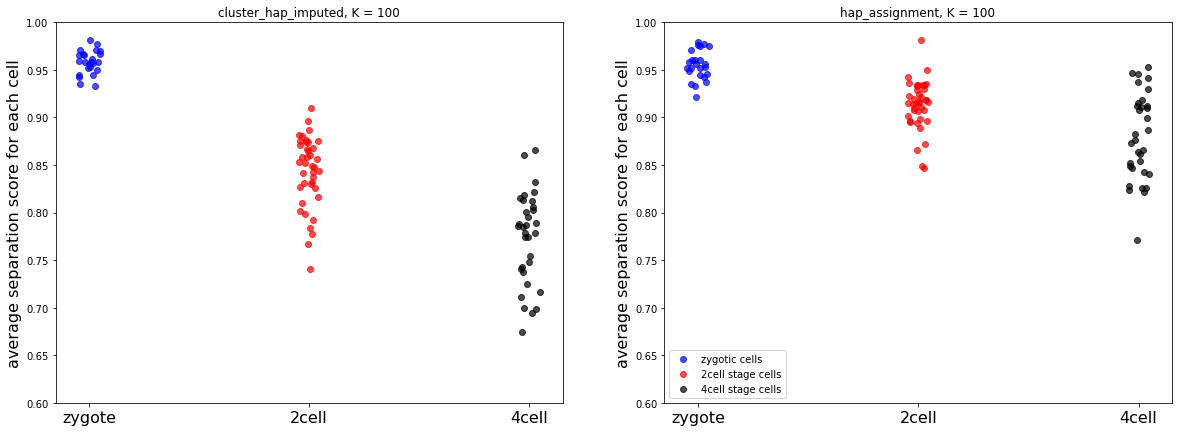

In [4]:
fig = plt.figure(figsize = (20,7))
K = 100

zygotes = pd.read_csv("separation_scores/zygote_sep_scores_K{}_hap_imputed.csv".format(K)) #size is reads X 3: cell_index, amp_ind, sep_score
_2cell = pd.read_csv("separation_scores/2cell_sep_scores_K{}_hap_imputed.csv".format(K))
_4cell = pd.read_csv("separation_scores/4cell_sep_scores_K{}_hap_imputed.csv".format(K))


#calucating the average of separation scores for each cell
zygote_scores = zygotes.groupby('cell_index').mean().separation_score
_2cell_scores = _2cell.groupby('cell_index').mean().separation_score
_4cell_scores = _4cell.groupby('cell_index').mean().separation_score

plt.subplot(1,2,1)
plt.scatter(np.zeros(zygote_scores.shape[0]) + np.random.uniform(-0.05, 0.05, size =zygote_scores.shape[0]), 
            zygote_scores, color = 'blue', marker = 'o', alpha = 0.7, label = "zygotic cells")
plt.scatter(np.ones(_2cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_2cell_scores.shape[0]),
            _2cell_scores, color = 'red', marker = 'o',alpha = 0.7,  label = "2cell stage cells")
plt.scatter(2*np.ones(_4cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_4cell_scores.shape[0]), 
            _4cell_scores, color = 'black', marker = 'o', alpha = 0.7, label = "4cell stage cells")

plt.ylim(0.6,1)
plt.xticks(ticks = [0,1,2], labels = ['zygote', '2cell', '4cell'], fontsize = 16)
plt.title("cluster_hap_imputed, K = {}".format(K))
plt.ylabel("average separation score for each cell", fontsize = 16)

######################### now for hap assignment ####################

zygotes = pd.read_csv("separation_scores/zygote_sep_scores_K{}.csv".format(K)) #size is reads X 3: cell_index, amp_ind, sep_score
_2cell = pd.read_csv("separation_scores/2cell_sep_scores_K{}.csv".format(K))
_4cell = pd.read_csv("separation_scores/4cell_sep_scores_K{}.csv".format(K))


#calucating the average of separation scores for each cell
zygote_scores = zygotes.groupby('cell_index').mean().separation_score
_2cell_scores = _2cell.groupby('cell_index').mean().separation_score
_4cell_scores = _4cell.groupby('cell_index').mean().separation_score

plt.subplot(1,2,2)
plt.scatter(np.zeros(zygote_scores.shape[0]) + np.random.uniform(-0.05, 0.05, size =zygote_scores.shape[0]), 
            zygote_scores, color = 'blue', marker = 'o', alpha = 0.7, label = "zygotic cells")
plt.scatter(np.ones(_2cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_2cell_scores.shape[0]),
            _2cell_scores, color = 'red', marker = 'o',alpha = 0.7,  label = "2cell stage cells")
plt.scatter(2*np.ones(_4cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_4cell_scores.shape[0]), 
            _4cell_scores, color = 'black', marker = 'o', alpha = 0.7, label = "4cell stage cells")

plt.ylim(0.6,1)
plt.xticks(ticks = [0,1,2], labels = ['zygote', '2cell', '4cell'], fontsize = 16)
plt.title("hap_assignment, K = {}".format(K))
plt.ylabel("average separation score for each cell", fontsize = 16)


plt.legend()
plt.savefig("figures/IGS_separation_score_hap_imputed.png")

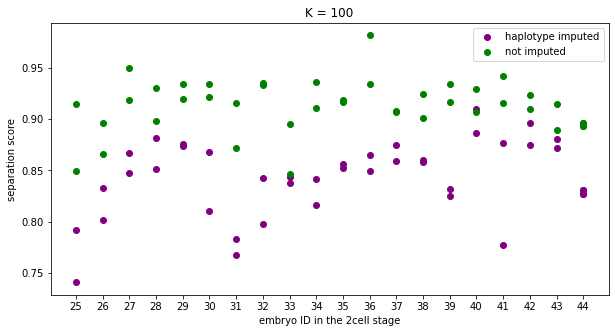

In [5]:
fig = plt.figure(figsize = (22,5))
embryos = data.loc[data.stage == '2cell', 'embryo_id'].unique()
K = 100
_2cell_imputed = pd.read_csv("separation_scores/2cell_sep_scores_K{}_hap_imputed.csv".format(K))
_2cell = pd.read_csv("separation_scores/2cell_sep_scores_K{}.csv".format(K))

for embryo in embryos:
    plt.subplot(1,2,1)
    joined_imputed = pd.merge(data.loc[data.embryo_id == embryo], _2cell_imputed, how = "inner" ,on = ['cell_index', 'amp_ind'])
    joined = pd.merge(data.loc[data.embryo_id == embryo], _2cell, how = "inner" ,on = ['cell_index', 'amp_ind'])
    plt.scatter(embryo * np.ones(2), joined_imputed.groupby('cell_index').mean().separation_score, color = 'purple', marker = 'o')
    plt.scatter(embryo * np.ones(2), joined.groupby('cell_index').mean().separation_score, color = 'green', marker = 'o')
    plt.xticks(embryos.astype(int)) 
    plt.xlabel("embryo ID in the 2cell stage")

    plt.title("K = {}".format(K))

    plt.ylabel("separation score")
plt.scatter(embryo * np.ones(2), joined_imputed.groupby('cell_index').mean().separation_score, color = 'purple', marker = 'o', label = "haplotype imputed")
plt.scatter(embryo * np.ones(2), joined.groupby('cell_index').mean().separation_score, color = 'green', marker = 'o', label = "not imputed")
plt.legend()
plt.savefig("figures/IGS_separation_score_hap_imputed_2cell.png")
plt.show()

### Now let's see if we can get the immediate neighbors of each chromosome

In [1]:
def get_neighbor_chromosoems(df_in: pd.DataFrame, 
                       chr_territory_in: str, #e.g. 10_1, 12_2, ...
                       num_neighbors: int,
                       visualize = False): #returns a list of 100 closest read_indices that are not in the same territory

    
    neighbor_chromosomes = np.array([])
    
    
    X = df_in[['x_um_abs', 'y_um_abs', 'z_um_abs']].copy()
    nbrs = NearestNeighbors(n_neighbors=2,  algorithm='ball_tree').fit(X) #setting n_neighbors to 2, because this function will first return the read itself, then its neighbor
    
    chr_territory_reads = df_in.loc[df_in.chr_territory == chr_territory_in, 'amp_ind'].unique()
    
    for read_idx in chr_territory_reads:
        
        
        read_pos = df_in.loc[df_in.amp_ind==read_idx, ['x_um_abs', 'y_um_abs', 'z_um_abs']]

        distances, indices = nbrs.kneighbors(read_pos) ## WARNING indices doesn't necessarily match the index col of the table, so don't use df.loc
        neighbors = df_in.iloc[indices[0]] #indices is a two-dim 1xN array. We index into it to make it one-dim array of size N
        
        #We pick the first neighbor, and if it belongs to the same chr_territory, we toss it out
        closest_neighbor = neighbors.iloc[1] #index 0 is the read_idx read itself. index 1 is the closest neighbor
        if neighbors.iloc[1].chr_territory != chr_territory_in:
            neighbor_chromosomes = np.append(neighbor_chromosomes, closest_neighbor.chr_territory)

    neighbor_chromosomes = np.unique(neighbor_chromosomes)
    if visualize:
    
        fig = plt.figure(figsize = (10,10))
        chr_territory_reads = df_in.loc[df_in.chr_territory == chr_territory_in]

        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        cmap=plt.get_cmap('hsv')
        ax.scatter(df_in.x_um_abs, df_in.y_um_abs, df_in.z_um_abs, s = 25, color = 'gray', marker = "o", alpha = 0.3, label= 'all reads')
        ax.scatter(chr_territory_reads.x_um_abs, chr_territory_reads.y_um_abs, chr_territory_reads.z_um_abs, s = 50, c = 'black', marker = "o", alpha = 0.9, label= 'given territory')
        for ter in neighbor_chromosomes:
            neighbors = df_in.loc[df_in.chr_territory ==ter]
            color = cmap(chr_ter_color_dict[ter]) 
            ax.scatter(neighbors.x_um_abs, neighbors.y_um_abs, neighbors.z_um_abs, s = 40, color = color, cmap = cmap, marker = "o", alpha = 0.4, label= ter)
        plt.legend(ncol = 2, fontsize=10)
        plt.title("immediate neighboring chromosomes")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    
    return neighbor_chromosomes
   
    
"""This function takes in a cell's data table, the chromosome territory of interest and its neighbors. 
If the territory of interest has a haplotype assignment, we return the fraction of neighbors_with_hap_assignment that match it.
if it doesn't have a hap assignment, we return the max fraction of paternal vs. maternal"""   
def calculate_highest_fraction(df_in: pd.DataFrame, 
                               neighbors: list[str],
                              ter: str): 
    #selecting only those neighbors that have a haplotype assignment
    assigned_neighbors = df_in.loc[(df_in.chr_territory.isin(neighbors)) & (df_in.cluster_hap_imputed != -1)]
    ter_hap_assignment = df_in.loc[df_in.chr_territory == ter, 'cluster_hap_imputed'].unique().item()
    hap_assignments = assigned_neighbors.groupby('chr_territory').mean().cluster_hap_imputed #e.g. [ 0,0,1,0,1,0]
    assert np.all(np.isin(hap_assignments,[0,1])), print(hap_assignments)
  
    if ter_hap_assignment != -1: #return the fraction of neighboring chromosomes that match the given territory hap assignment
        return np.mean(hap_assignments == ter_hap_assignment)
    else:
        return max(np.mean(hap_assignments), 1 - np.mean(hap_assignments))


def return_separation_scores(data_in):
    t_start = time.time()
    data = data_in.copy()
    cell_indices = data.cell_index.unique()

    for cell_index in cell_indices:
        print("cell index: ", cell_index)
        cell = data.loc[data.cell_index == cell_index]
        if cell.shape[0] > 150: #excluding cells with low coverage
            territories = cell.chr_territory.unique()
            for ter in territories:
                neighbors = get_neighbor_chromosoems(cell, ter, False)
                data.loc[(data.cell_index == cell_index) & (data.chr_territory == ter),['num_immediate_chr_neighbors']] = len(neighbors)
                data.loc[(data.cell_index == cell_index) & (data.chr_territory == ter),['chr_separation_score']] = calculate_highest_fraction(cell, neighbors, ter)
        print(time.time() - t_start)
    
    return data[['cell_index', 'amp_ind','chr_separation_score','num_immediate_chr_neighbors' ]]
     

NameError: name 'pd' is not defined

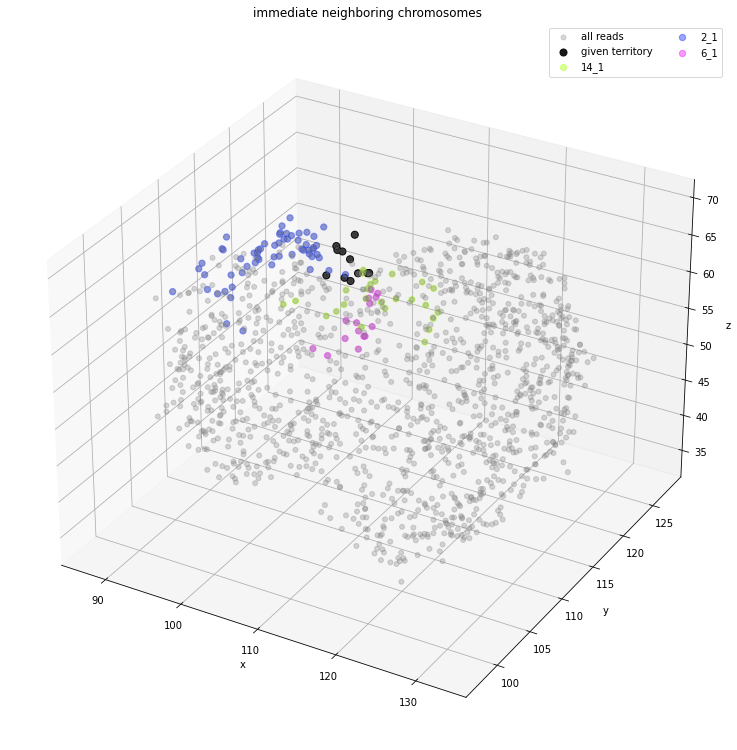

array(['14_1', '2_1', '6_1'], dtype='<U32')

In [5]:
cell_1 = data.loc[data.cell_index==5]
get_neighbor_chromosoems(cell_1, '19_1',2, True)

In [23]:
scores = return_separation_scores(data)
scores.to_csv("separation_scores/chr_sep_scores.csv", index = False)

cell index:  1
14.270435810089111
cell index:  2
17.883427143096924
cell index:  3
23.067859649658203
cell index:  4
29.258144855499268
cell index:  5
33.25921010971069
cell index:  6
42.46849203109741
cell index:  7
58.45551013946533
cell index:  8
74.91054844856262
cell index:  9
81.7680401802063
cell index:  10
95.0571448802948
cell index:  11
106.74602341651917
cell index:  12
111.17080807685852
cell index:  13
124.77454781532288
cell index:  14
134.40424227714539
cell index:  15
142.9108669757843
cell index:  16
149.31953120231628
cell index:  17
157.6471872329712
cell index:  18
173.06721663475037
cell index:  19
178.6670753955841
cell index:  20
188.45574259757996
cell index:  21
202.83583164215088
cell index:  22
207.82043623924255
cell index:  23
214.97753024101257
cell index:  24
227.1620156764984
cell index:  25
229.56840920448303
cell index:  26
232.48953127861023
cell index:  27
237.3630223274231
cell index:  28
241.84417176246643
cell index:  29
248.81921482086182
cell in

In [24]:
scores

,cell_index,amp_ind,chr_separation_score
0,1,1,1.000000
1,1,3,0.785714
2,1,5,0.600000
3,1,6,1.000000
4,1,9,1.000000
...,...,...,...
230055,112,8058,0.666667
230056,112,8066,1.000000
230057,112,8069,0.800000
230058,112,8101,0.666667


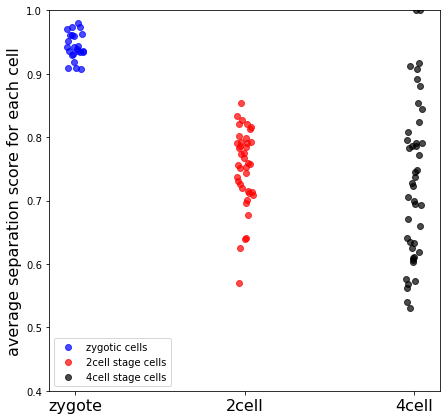

In [115]:
fig = plt.figure(figsize = (7,7))
scores = pd.read_csv("separation_scores/chr_sep_scores.csv")
joined = pd.merge(data, scores, how = "inner" ,on = ['cell_index', 'amp_ind'])



     #size is reads X 3: cell_index, amp_ind, sep_score
    

#calucating the average of separation scores for each cell
zygote_scores = joined.loc[joined.stage=='zygote'].groupby('cell_index').mean().chr_separation_score
_2cell_scores = joined.loc[joined.stage=='2cell'].groupby('cell_index').mean().chr_separation_score
_4cell_scores = joined.loc[joined.stage=='4cell'].groupby('cell_index').mean().chr_separation_score


plt.scatter(np.zeros(zygote_scores.shape[0]) + np.random.uniform(-0.05, 0.05, size =zygote_scores.shape[0]), 
            zygote_scores, color = 'blue', marker = 'o', alpha = 0.7, label = "zygotic cells")
plt.scatter(np.ones(_2cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_2cell_scores.shape[0]),
            _2cell_scores, color = 'red', marker = 'o',alpha = 0.7,  label = "2cell stage cells")
plt.scatter(2*np.ones(_4cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_4cell_scores.shape[0]), 
            _4cell_scores, color = 'black', marker = 'o', alpha = 0.7, label = "4cell stage cells")

plt.ylim(0.4,1)
plt.xticks(ticks = [0,1,2], labels = ['zygote', '2cell', '4cell'], fontsize = 16)
# plt.title("K = {}".format(K))
plt.ylabel("average separation score for each cell", fontsize = 16)


plt.legend()
plt.savefig("figures/chr_separation_scores.png")

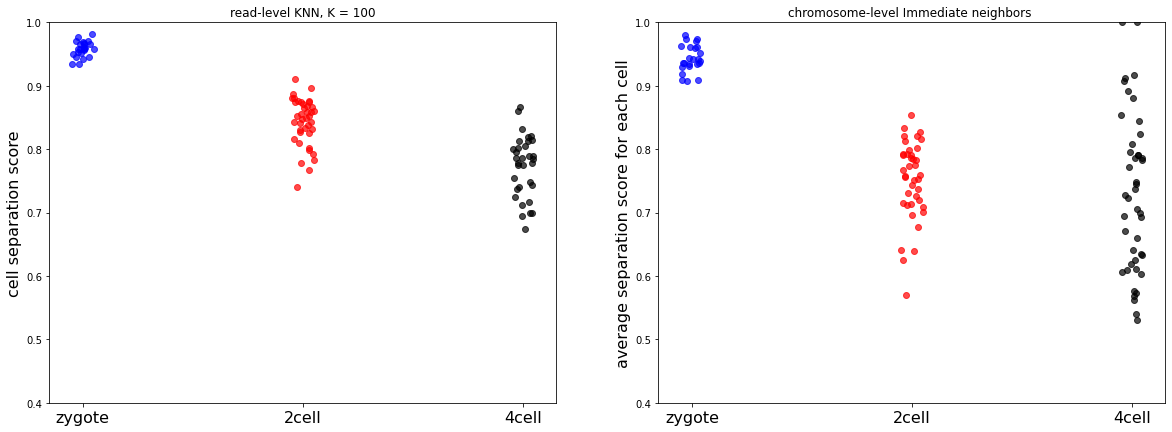

In [8]:
fig = plt.figure(figsize = (20,7))
K = 100

zygotes = pd.read_csv("separation_scores/zygote_sep_scores_K{}_hap_imputed.csv".format(K)) #size is reads X 3: cell_index, amp_ind, sep_score
_2cell = pd.read_csv("separation_scores/2cell_sep_scores_K{}_hap_imputed.csv".format(K))
_4cell = pd.read_csv("separation_scores/4cell_sep_scores_K{}_hap_imputed.csv".format(K))


#calucating the average of separation scores for each cell
zygote_scores = zygotes.groupby('cell_index').mean().separation_score
_2cell_scores = _2cell.groupby('cell_index').mean().separation_score
_4cell_scores = _4cell.groupby('cell_index').mean().separation_score

plt.subplot(1,2,1)
plt.scatter(np.zeros(zygote_scores.shape[0]) + np.random.uniform(-0.05, 0.05, size =zygote_scores.shape[0]), 
            zygote_scores, color = 'blue', marker = 'o', alpha = 0.7, label = "zygotic cells")
plt.scatter(np.ones(_2cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_2cell_scores.shape[0]),
            _2cell_scores, color = 'red', marker = 'o',alpha = 0.7,  label = "2cell stage cells")
plt.scatter(2*np.ones(_4cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_4cell_scores.shape[0]), 
            _4cell_scores, color = 'black', marker = 'o', alpha = 0.7, label = "4cell stage cells")

plt.ylim(0.4,1)
plt.xticks(ticks = [0,1,2], labels = ['zygote', '2cell', '4cell'], fontsize = 16)
plt.title("read-level KNN, K = {}".format(K))
plt.ylabel("cell separation score", fontsize = 16)


######## 

scores = pd.read_csv("separation_scores/chr_sep_scores.csv")
joined = pd.merge(data, scores, how = "inner" ,on = ['cell_index', 'amp_ind'])



     #size is reads X 3: cell_index, amp_ind, sep_score
    

#calucating the average of separation scores for each cell
zygote_scores = joined.loc[joined.stage=='zygote'].groupby('cell_index').mean().chr_separation_score
_2cell_scores = joined.loc[joined.stage=='2cell'].groupby('cell_index').mean().chr_separation_score
_4cell_scores = joined.loc[joined.stage=='4cell'].groupby('cell_index').mean().chr_separation_score

plt.subplot(1,2,2)
plt.scatter(np.zeros(zygote_scores.shape[0]) + np.random.uniform(-0.05, 0.05, size =zygote_scores.shape[0]), 
            zygote_scores, color = 'blue', marker = 'o', alpha = 0.7, label = "zygotic cells")
plt.scatter(np.ones(_2cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_2cell_scores.shape[0]),
            _2cell_scores, color = 'red', marker = 'o',alpha = 0.7,  label = "2cell stage cells")
plt.scatter(2*np.ones(_4cell_scores.shape[0])+ np.random.uniform(-0.05, 0.05, size =_4cell_scores.shape[0]), 
            _4cell_scores, color = 'black', marker = 'o', alpha = 0.7, label = "4cell stage cells")

plt.ylim(0.4,1)
plt.xticks(ticks = [0,1,2], labels = ['zygote', '2cell', '4cell'], fontsize = 16)
plt.title("chromosome-level Immediate neighbors ")
plt.ylabel("average separation score for each cell", fontsize = 16)


plt.savefig("figures/chr_vs_KNN_separation_scores.png")



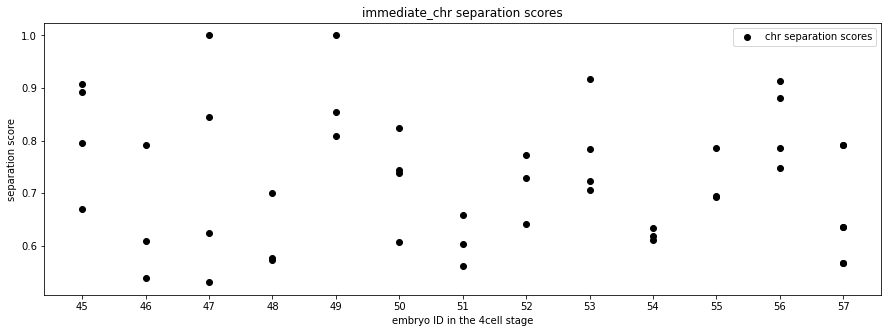

In [21]:
fig = plt.figure(figsize = (15,5))
embryos = data.loc[data.stage == '4cell', 'embryo_id'].unique()
my_scores = pd.read_csv("separation_scores/immediate_chr_sep_scores.csv")
igs_scores = pd.read_csv("separation_scores/4cell_sep_scores_K100_hap_imputed.csv")
    
for embryo in embryos:

    my_joined = pd.merge(data.loc[data.embryo_id == embryo], my_scores, how = "inner" ,on = ['cell_index', 'amp_ind'])
#     igs_joined = pd.merge(data.loc[data.embryo_id == embryo], igs_scores, how = "inner" ,on = ['cell_index', 'amp_ind'])
    cells_in_embryo = my_joined.groupby('cell_index').mean().chr_separation_score
    plt.scatter(embryo * np.ones(len(cells_in_embryo)), my_joined.groupby('cell_index').mean().chr_separation_score, color = 'black', marker = 'o')
#     plt.scatter(embryo * np.ones(len(cells_in_embryo)), igs_joined.groupby('cell_index').mean().separation_score, color = 'red', marker = 'o')

    plt.xticks(embryos.astype(int)) 
    plt.xlabel("embryo ID in the 4cell stage")

    plt.title("immediate_chr separation scores")
    plt.ylabel("separation score")
plt.scatter(embryo * np.ones(len(cells_in_embryo)), my_joined.groupby('cell_index').mean().chr_separation_score, color = 'black', marker = 'o', label = "chr separation scores")
# plt.scatter(embryo * np.ones(len(cells_in_embryo)), igs_joined.groupby('cell_index').mean().separation_score, color = 'red', marker = 'o', label = "IGS separation scores")
plt.legend()
plt.savefig("figures/immediate_chr_separation_scores_4cell.png")
plt.show()

In [76]:
X = np.array([0,1,0,1])


In [80]:
assert np.all(x.isin([0,1]) for x in X)

In [87]:
np.all(np.isin(X,[0,1]))

True